In [53]:
import os
import pandas as pd

In [54]:
os.chdir("/Users/manoj/OneDrive/Documents/Manoj/Resume/Projects/Doordash Churn Analysis")

In [55]:
orders=pd.read_csv("Orders.csv")
users = pd.read_csv("Users.csv")

In [56]:
orders.head()


,user_id,order_id,order_date,order_amount,delivery_time_mins,used_promo,delivery_fee,order_time
0,U0000,O727220,2023-10-20,30.14,37,1,3.83,Evening
1,U0000,O915948,2023-12-20,27.82,46,1,0.00,Evening
2,U0000,O576513,2023-07-12,7.95,10,1,2.73,Evening
3,U0000,O564894,2023-09-06,23.12,20,0,3.70,Afternoon
4,U0000,O134518,2023-07-23,28.88,24,1,4.13,Evening


In [57]:
users.head()

,user_id,signup_date,user_location,platform
0,U0000,2023-04-13,Houston,iOS
1,U0001,2023-12-15,Houston,iOS
2,U0002,2023-09-28,Dallas,iOS
3,U0003,2023-04-17,Austin,iOS
4,U0004,2023-03-13,Austin,iOS


In [58]:
orders["order_date"] = pd.to_datetime(orders["order_date"])
users["signup_date"] = pd.to_datetime(users["signup_date"])

In [59]:
# Add month and weekday columns for analysis
orders["month"] = orders["order_date"].dt.to_period("M")
orders["weekday"] = orders["order_date"].dt.day_name()


In [60]:
users["cohort_month"] = users["signup_date"].dt.to_period("M")


# Merge orders with user info
orders_merged = pd.merge(orders, users[["user_id", "cohort_month"]], on="user_id")

orders_merged.head()

,user_id,order_id,order_date,order_amount,delivery_time_mins,used_promo,delivery_fee,order_time,month,weekday,cohort_month
0,U0000,O727220,2023-10-20,30.14,37,1,3.83,Evening,2023-10,Friday,2023-04
1,U0000,O915948,2023-12-20,27.82,46,1,0.00,Evening,2023-12,Wednesday,2023-04
2,U0000,O576513,2023-07-12,7.95,10,1,2.73,Evening,2023-07,Wednesday,2023-04
3,U0000,O564894,2023-09-06,23.12,20,0,3.70,Afternoon,2023-09,Wednesday,2023-04
4,U0000,O134518,2023-07-23,28.88,24,1,4.13,Evening,2023-07,Sunday,2023-04


In [61]:
#Calculate cohort index (how many months since signup)
orders_merged["cohort_index"] = (
    (orders_merged["month"] - orders_merged["cohort_month"]).apply(lambda x: x.n)
)

#Create a retention matrix (users who placed orders by cohort and month)
retention = (
    orders_merged
    .groupby(["cohort_month", "cohort_index"])["user_id"]
    .nunique()
    .unstack()
    .fillna(0)
)

#Normalize to get retention rates
cohort_sizes = retention.iloc[:, 0]  # Month 0 users
retention_rate = retention.divide(cohort_sizes, axis=0).round(3)

# View the retention_rate table
retention_rate.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_month,,,,,,,,,,,,,,,
2023-01,1.0,2.600,2.400,2.800,2.400,1.800,2.300,1.800,2.500,2.100,2.000,1.900,2.500,1.800,0.7
2023-02,1.0,2.357,2.786,1.786,1.714,1.857,1.571,1.857,2.143,1.857,2.143,1.857,2.000,1.357,0.0
2023-03,1.0,2.857,3.000,2.286,3.143,2.286,3.143,2.857,1.714,3.000,2.000,3.286,1.857,0.000,0.0
2023-04,1.0,2.067,1.867,1.867,2.133,2.200,2.267,1.733,1.667,2.267,1.333,0.800,0.000,0.000,0.0
2023-05,1.0,1.722,1.611,1.722,1.778,1.944,1.389,1.389,1.333,1.444,0.889,0.000,0.000,0.000,0.0


In [62]:
# 1. Orders per month
orders_per_month = orders.groupby("month")["order_id"].count()

# 2. Average order amount per month
avg_order_amount = orders.groupby("month")["order_amount"].mean()

# 3. Delivery time distribution
delivery_time = orders["delivery_time_mins"]

# 4. Promo usage rate (0 = no, 1 = yes)
promo_usage = orders["used_promo"].value_counts(normalize=True)

# 5. Orders by time of day
order_time_dist = orders["order_time"].value_counts()


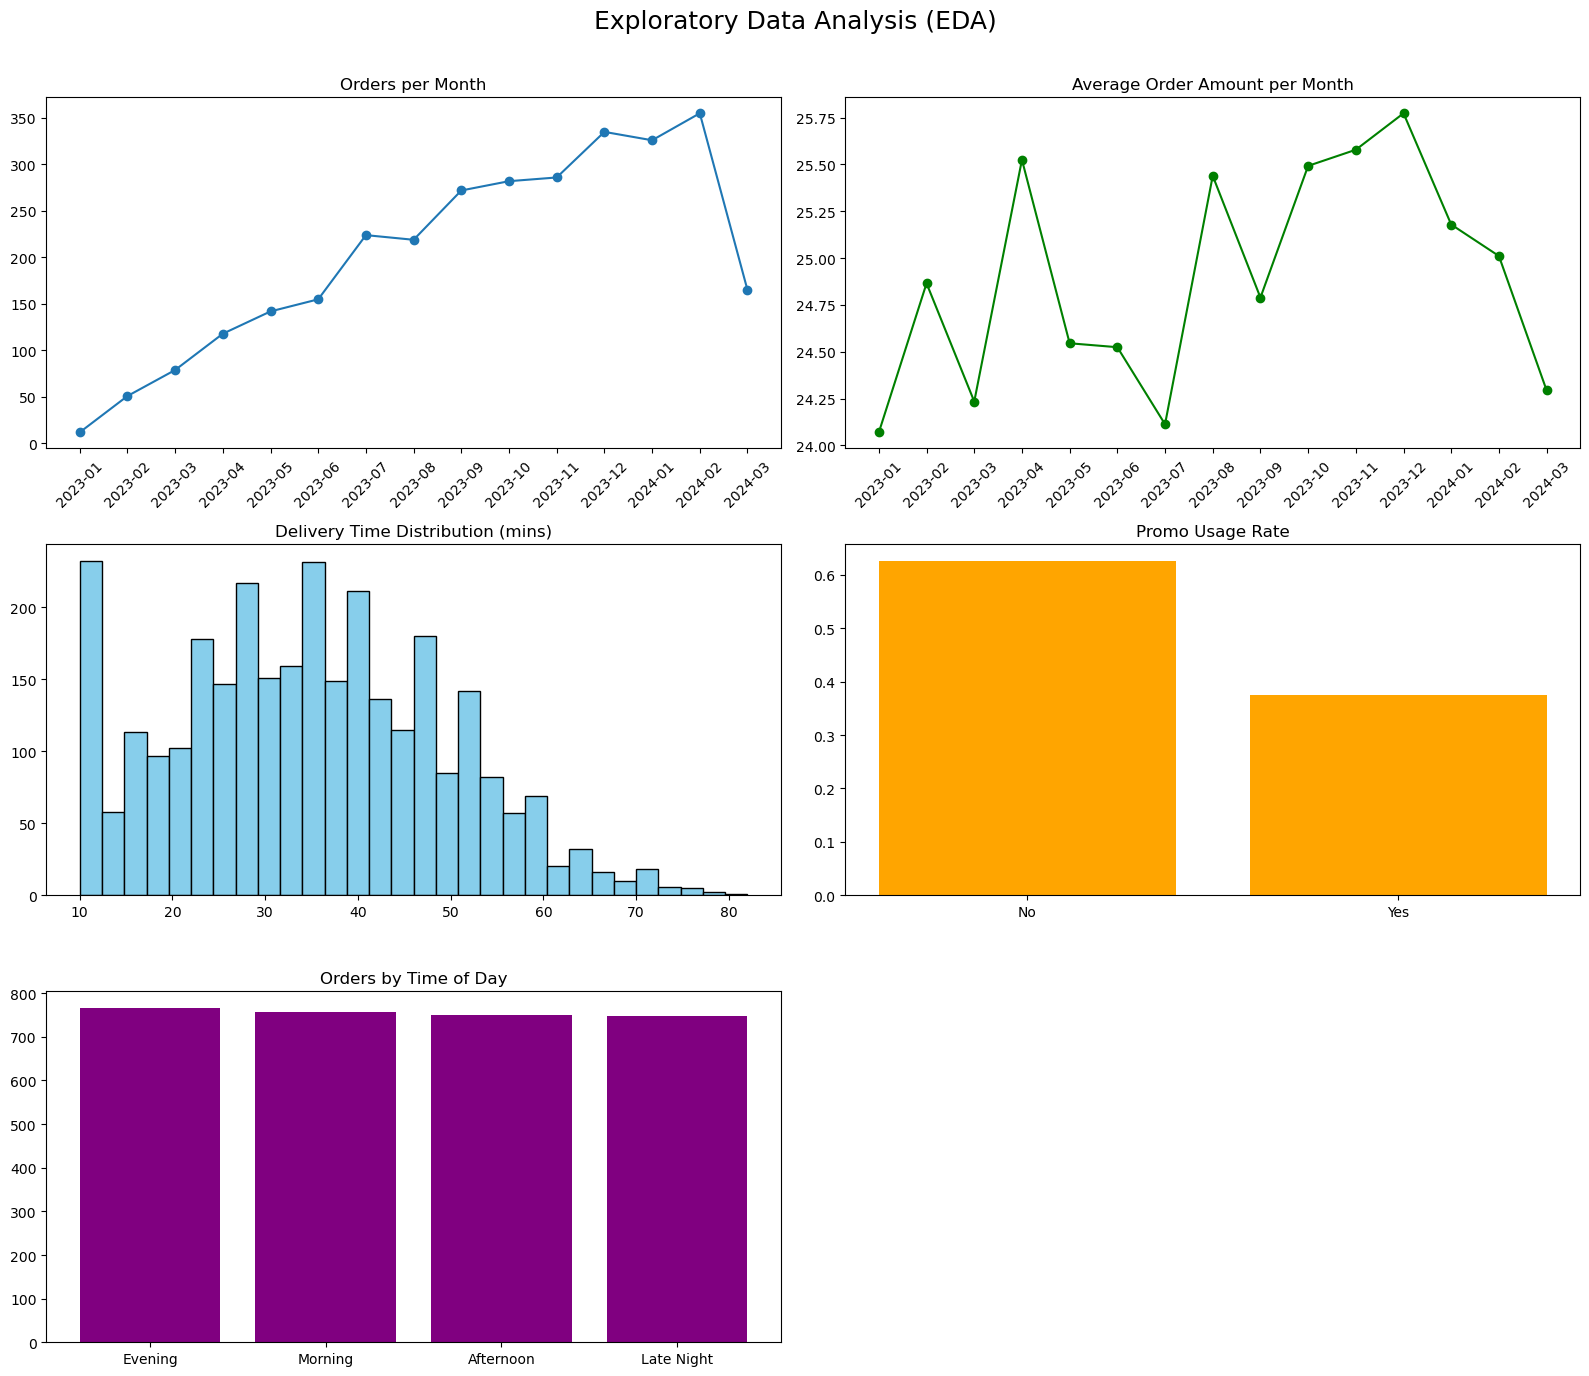

In [63]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Exploratory Data Analysis (EDA)", fontsize=18)


axs[0, 0].plot(orders_per_month.index.astype(str), orders_per_month.values, marker='o')
axs[0, 0].set_title("Orders per Month")
axs[0, 0].tick_params(axis='x', rotation=45)


axs[0, 1].plot(avg_order_amount.index.astype(str), avg_order_amount.values, color='green', marker='o')
axs[0, 1].set_title("Average Order Amount per Month")
axs[0, 1].tick_params(axis='x', rotation=45)


axs[1, 0].hist(delivery_time, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].set_title("Delivery Time Distribution (mins)")


axs[1, 1].bar(promo_usage.index.astype(str), promo_usage.values, color='orange')
axs[1, 1].set_title("Promo Usage Rate")
axs[1, 1].set_xticks([0, 1])
axs[1, 1].set_xticklabels(["No", "Yes"])


axs[2, 0].bar(order_time_dist.index, order_time_dist.values, color='purple')
axs[2, 0].set_title("Orders by Time of Day")


axs[2, 1].axis('off')  # Hide the last unused chart

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



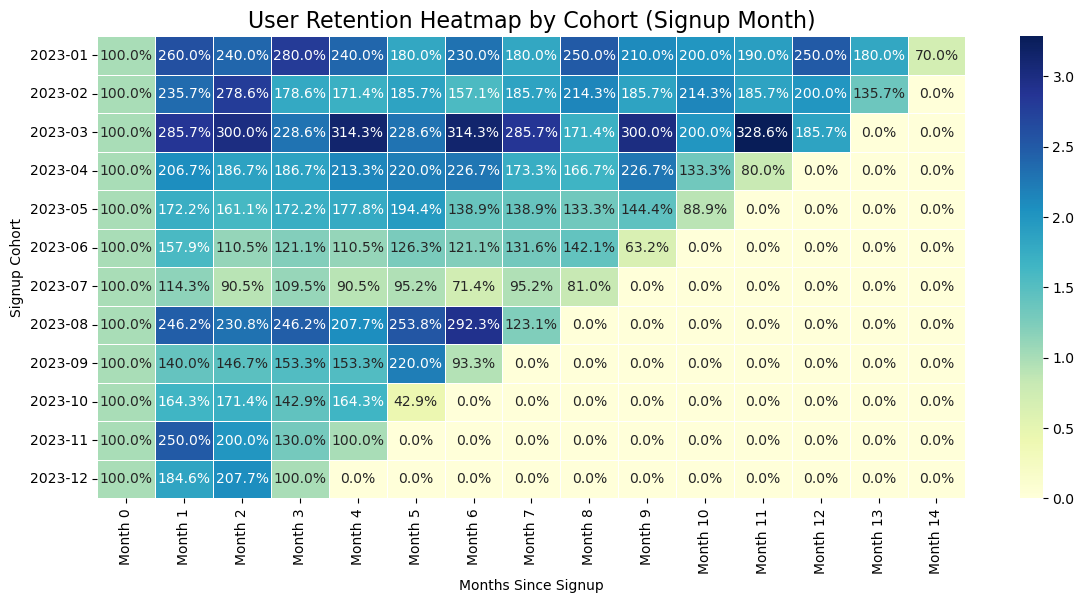

In [64]:
import seaborn as sns

# Convert Period index to string for display
retention_rate.index = retention_rate.index.astype(str)
retention_rate.columns = [f"Month {i}" for i in retention_rate.columns]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(retention_rate, annot=True, fmt=".1%", cmap="YlGnBu", linewidths=.5)
plt.title("User Retention Heatmap by Cohort (Signup Month)", fontsize=16)
plt.ylabel("Signup Cohort")
plt.xlabel("Months Since Signup")
plt.yticks(rotation=0)
plt.show()


In [65]:
#Churn Analysis
#Churned User = A user who hasn't placed an order in the last 60 days.
from datetime import datetime

# Step 1: Define data cutoff and churn window
cutoff_date = datetime(2024, 3, 15)
churn_threshold_days = 60

# Step 2: Get the most recent order date for each user
last_order_dates = orders.groupby("user_id")["order_date"].max().reset_index()
last_order_dates.rename(columns={"order_date": "last_order_date"}, inplace=True)

# Step 3: Merge with users
users_churn = users.merge(last_order_dates, on="user_id", how="left")

# Step 4: Calculate days since last order
users_churn["days_since_last_order"] = (cutoff_date - users_churn["last_order_date"]).dt.days

# Step 5: Flag churn
users_churn["is_churned"] = users_churn["days_since_last_order"] > churn_threshold_days

# View the result
users_churn[["user_id", "last_order_date", "days_since_last_order", "is_churned"]].head()



,user_id,last_order_date,days_since_last_order,is_churned
0,U0000,2023-12-20,86.0,True
1,U0001,NaT,NaN,False
2,U0002,2023-12-25,81.0,True
3,U0003,2023-12-04,102.0,True
4,U0004,2024-03-01,14.0,False


In [66]:
# 1. Total Orders per User
f1 = orders.groupby("user_id")["order_id"].count().reset_index(name="total_orders")

# 2. Average Order Amount
f2 = orders.groupby("user_id")["order_amount"].mean().reset_index(name="avg_order_amount")

# 3. Average Delivery Time
f3 = orders.groupby("user_id")["delivery_time_mins"].mean().reset_index(name="avg_delivery_time")

# 4. Promo Usage Rate
f4 = orders.groupby("user_id")["used_promo"].mean().reset_index(name="promo_usage_rate")

# 5. Orders by Time of Day (% Late Night Orders)
late_night_orders = orders[orders["order_time"] == "Late Night"]
f5 = late_night_orders.groupby("user_id")["order_id"].count().reset_index(name="late_night_orders")
f5_total = orders.groupby("user_id")["order_id"].count().reset_index(name="total_orders_2")
f5 = pd.merge(f5, f5_total, on="user_id", how="right").fillna(0)
f5["late_night_pct"] = f5["late_night_orders"] / f5["total_orders_2"]
f5 = f5[["user_id", "late_night_pct"]]

# 6. Days Since Last Order
from datetime import datetime
cutoff_date = datetime(2024, 3, 15)
last_order = orders.groupby("user_id")["order_date"].max().reset_index()
last_order["days_since_last_order"] = (cutoff_date - last_order["order_date"]).dt.days
f6 = last_order[["user_id", "days_since_last_order"]]

# 7. Platform and Location (from users_df)
f7 = users[["user_id", "platform", "user_location"]]

# Merge all features
from functools import reduce
dfs = [f1, f2, f3, f4, f5, f6, f7]
features_df = reduce(lambda left, right: pd.merge(left, right, on="user_id", how="left"), dfs)

# Add churn label from earlier
features_df = pd.merge(features_df, users_churn[["user_id", "is_churned"]], on="user_id", how="left")

features_df.head()


,user_id,total_orders,avg_order_amount,avg_delivery_time,promo_usage_rate,late_night_pct,days_since_last_order,platform,user_location,is_churned
0,U0000,6,22.260000,31.333333,0.833333,0.000000,86,iOS,Houston,True
1,U0002,1,8.940000,46.000000,0.000000,1.000000,81,iOS,Dallas,True
2,U0003,4,24.817500,49.250000,0.750000,0.250000,102,iOS,Austin,True
3,U0004,4,18.690000,28.500000,0.250000,0.250000,14,iOS,Austin,False
4,U0005,3,26.493333,27.000000,0.666667,0.666667,60,Web,Plano,False


In [68]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Define churn probabilistically
def churn_probability(row):
    prob = 0.1
    if row["days_since_last_order"] > 90:
        prob += 0.4
    if row["avg_delivery_time"] > 45:
        prob += 0.2
    if row["promo_usage_rate"] < 0.2:
        prob += 0.2
    if row["total_orders"] < 3:
        prob += 0.1
    return min(prob, 0.95)

features_df["churn_prob"] = features_df.apply(churn_probability, axis=1)
features_df["is_churned"] = features_df["churn_prob"].apply(lambda x: np.random.rand() < x).astype(int)

# Step 2: Prepare features and target
X = features_df.drop(columns=["user_id", "churn_prob", "is_churned"])
X = pd.get_dummies(X, drop_first=True)  # One-hot encode platform & user_location
y = features_df["is_churned"]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predictions & evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.76      0.76      0.76       115
           1       0.57      0.57      0.57        65

    accuracy                           0.69       180
   macro avg       0.66      0.66      0.66       180
weighted avg       0.69      0.69      0.69       180

ROC AUC: 0.7012040133779265


In [69]:
#Export to build dashboard
features_df.to_csv("doordash_churn_dashboard.csv", index=False)
